## Here we will try our best shot to predict the goals with our features

In [439]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [440]:
%cd /content/gdrive/MyDrive/Master_UdeM/IFT-6758/Project/ift6758-project-main

/content/gdrive/MyDrive/Master_UdeM/IFT-6758/Project/ift6758-project-main


In [441]:
#!git clone https://GIT_TOKEN@github.com/M0rph3e/ift6758-project-main.git #not anymore
! git pull

remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 20 (delta 11), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (20/20), done.
From https://github.com/M0rph3e/ift6758-project-main
   ab53ff0..04f14dd  main       -> origin/main
Updating ab53ff0..04f14dd
Fast-forward
 notebooks/try_your_best_shot.ipynb       | 2032 +++++++++++++++--------------
 notebooks/try_your_best_shot_keras.ipynb | 2041 +++++++++++++-----------------
 2 files changed, 1896 insertions(+), 2177 deletions(-)


In [442]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ift6758/features/feature_engineering2.py
	modified:   ift6758/metrics/plot_metrics.py

no changes added to commit (use "git add" and/or "git commit -a")


In [541]:
!pip install comet_ml pandas-profiling==2.7.1

  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: pandas-profiling
    Found existing installation: pandas-profiling 1.4.1
    Uninstalling pandas-profiling-1.4.1:
      Successfully uninstalled pandas-profiling-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [444]:
! git branch

  best_shot_trial
  fengineering2
* main


# Real **** starts from here

In [445]:
from ift6758.features.feature_engineering2 import SeasonDataSetTwo
from ift6758.data.data_acquisition import Season
from ift6758.visualizations.simple_visualization import Utilities 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import random
import pandas as pd
import pickle
import sys
import json

import warnings
warnings.filterwarnings("ignore")

In [501]:
train_years = [2015,2016,2017]
valid_years = [2018]
test_years=[2019]


train_dataset = SeasonDataSetTwo(train_years)
valid_dataset = SeasonDataSetTwo(valid_years)
train_df = train_dataset.get_features_2()
valid_df = valid_dataset.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2015_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2015_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2016_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2016_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2017_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2017_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2018_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2018_period_info.pkl


In [502]:
test_data = SeasonDataSetTwo(test_years)
test_df = test_data.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2019_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2019_period_info.pkl


# for Part 7

In [503]:
#test_df['gamePk'].astype(str).str[5].unique()
test_df_regular = test_df[test_df['gamePk'].astype(str).str[5]=='2']
test_df_playoff = test_df[test_df['gamePk'].astype(str).str[5]=='3']

# Export the data csv to comet

In [ ]:
from comet_ml import Experiment
import os



exp = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),
    project_name='milestone-2',
    workspace='morph-e',
    log_code=True,
    log_graph=True,
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/morph-e/milestone-2/2de74906d5ad42c0913ded110a44d306



In [ ]:
exp.log_dataframe_profile(
train_df, 
name='train_set_from_FE2',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)

exp.log_dataframe_profile(
valid_df, 
name='valid_set_from_FE2',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)

exp.log_dataframe_profile(
test_df, 
name='test_set_from_FE2',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)


COMET WARNING: unable to profile dataframe; ignoring
COMET WARNING: unable to profile dataframe; ignoring
COMET WARNING: unable to profile dataframe; ignoring


{'dataframe': {'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=4a1ec1be94d641b6a9fdf5a03ed78719&experimentKey=2de74906d5ad42c0913ded110a44d306',
  'assetId': '4a1ec1be94d641b6a9fdf5a03ed78719',
  'web': 'https://www.comet.ml/api/asset/download?assetId=4a1ec1be94d641b6a9fdf5a03ed78719&experimentKey=2de74906d5ad42c0913ded110a44d306'},
 'profile': None}

# Split and shuffle Data

In [504]:
random.seed(42)

In [505]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)
valid_df = valid_df.sample(frac=1)
#for part 7
test_df_regular = test_df_regular.sample(frac=1)
test_df_playoff = test_df_playoff.sample(frac=1)

In [506]:
train_df.head()

,result.penaltySeverity,result.penaltyMinutes,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,result.strength.name,gameSeconds,shotDistance,shotAngle,isGoal,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
218351,NaN,NaN,2017020911,Dallas Stars,3,-75.0,0.0,Wrist Shot,False,Even,335.0,14.000000,0.000000,1,Faceoff,69.0,-22.0,30.0,145.670862,False,4.855695,0.0,0.0
14001,NaN,NaN,2015020235,Tampa Bay Lightning,2,-57.0,-20.0,Wrist Shot,0,NaN,220.0,37.735925,-32.005383,0,Blocked Shot,72.0,-11.0,29.0,129.313572,False,4.459089,0.0,0.0
77497,NaN,NaN,2015030233,Dallas Stars,2,78.0,-22.0,Wrist Shot,0,NaN,487.0,24.596748,63.434949,0,Takeaway,97.0,-7.0,15.0,24.207437,False,1.613829,0.0,0.0
83095,NaN,NaN,2016020065,Boston Bruins,1,74.0,-6.0,Snap Shot,0,NaN,428.0,16.155494,21.801409,0,Missed Shot,69.0,2.0,9.0,9.433981,False,1.048220,0.0,0.0
209118,NaN,NaN,2017020769,Winnipeg Jets,3,-73.0,2.0,Wrist Shot,0,NaN,729.0,16.124515,7.125016,0,Blocked Shot,-77.0,10.0,6.0,8.944272,False,1.490712,0.0,0.0


## Here I am going to do more features selection (add strength) and change the preprocessing (no need to one hot with random forest),
## I will also try to find the best feature with $Χ^2$
## (Need to remove negative values features that I don't find interesting by intuition such as coordinates)

In [532]:
features = ['gameSeconds','timeFromLastEvent','gamePeriod','shotType','result.strength.name', 'shotAngle', 'shotDistance','distanceFromLastEvent', 'rebound','speed','changeInShotAngle','angleSpeed']
label = ['isGoal']

In [508]:
train_df[features].isna().any()
valid_df[features].isna().any()
test_df[features].isna().any()

test_df_regular[features].isna().any()
test_df_playoff[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                  True
result.strength.name      True
shotAngle                False
shotDistance             False
distanceFromLastEvent     True
rebound                  False
speed                     True
changeInShotAngle        False
angleSpeed                True
dtype: bool

## Treat the 'strength name case now (want to put it into categorical data (nan are 0)

In [509]:
train_df['result.strength.name'] = train_df['result.strength.name'].fillna('Unknown')
valid_df['result.strength.name'] = valid_df['result.strength.name'].fillna('Unknown')
test_df['result.strength.name'] = test_df['result.strength.name'].fillna('Unknown')

test_df_regular['result.strength.name'] = test_df_regular['result.strength.name'].fillna('Unknown')
test_df_playoff['result.strength.name'] = test_df_playoff['result.strength.name'].fillna('Unknown')

In [510]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(train_df[['result.strength.name']])

OrdinalEncoder()

In [511]:
train_df[['result.strength.name']] = enc.transform(train_df[['result.strength.name']]).astype(int)
valid_df[['result.strength.name']] = enc.transform(valid_df[['result.strength.name']]).astype(int)
test_df[['result.strength.name']] = enc.transform(test_df[['result.strength.name']]).astype(int)

test_df_regular[['result.strength.name']] = enc.transform(test_df_regular[['result.strength.name']]).astype(int)
test_df_playoff[['result.strength.name']] = enc.transform(test_df_playoff[['result.strength.name']]).astype(int)

### Replace inf with nan (annoying in normalization)

In [512]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

test_df_regular.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df_playoff.replace([np.inf, -np.inf], np.nan, inplace=True)

In [513]:
#drop rows with nan
train_df = train_df[train_df['shotType'].notna()]
valid_df = valid_df[valid_df['shotType'].notna()]
test_df = test_df[test_df['shotType'].notna()]
test_df_regular = test_df_regular[test_df_regular['shotType'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['shotType'].notna()]

train_df = train_df[train_df['shotAngle'].notna()]
valid_df = valid_df[valid_df['shotAngle'].notna()]
test_df = test_df[test_df['shotAngle'].notna()]
test_df_regular = test_df_regular[test_df_regular['shotAngle'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['shotAngle'].notna()]

train_df = train_df[train_df['shotDistance'].notna()]
valid_df = valid_df[valid_df['shotDistance'].notna()]
test_df = test_df[test_df['shotDistance'].notna()]
test_df_regular = test_df_regular[test_df_regular['shotDistance'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['shotDistance'].notna()]

train_df = train_df[train_df['speed'].notna()]
valid_df = valid_df[valid_df['speed'].notna()]
test_df = test_df[test_df['speed'].notna()]
test_df_regular = test_df_regular[test_df_regular['speed'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['speed'].notna()]

train_df = train_df[train_df['changeInShotAngle'].notna()]
valid_df = valid_df[valid_df['changeInShotAngle'].notna()]
test_df = test_df[test_df['changeInShotAngle'].notna()]
test_df_regular = test_df_regular[test_df_regular['changeInShotAngle'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['changeInShotAngle'].notna()]

"""
train_df = train_df[train_df['coordinatesX'].notna()]
valid_df = valid_df[valid_df['coordinatesX'].notna()]
test_df = test_df[test_df['coordinatesX'].notna()]
test_df_regular = test_df_regular[test_df_regular['coordinatesX'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['coordinatesX'].notna()]

train_df = train_df[train_df['coordinatesY'].notna()]
valid_df = valid_df[valid_df['coordinatesY'].notna()]
test_df = test_df[test_df['coordinatesY'].notna()]
test_df_regular = test_df_regular[test_df_regular['coordinatesY'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['coordinatesY'].notna()]

train_df = train_df[train_df['lastEventCoordinatesY'].notna()]
valid_df = valid_df[valid_df['lastEventCoordinatesY'].notna()]
test_df = test_df[test_df['lastEventCoordinatesY'].notna()]
test_df_regular = test_df_regular[test_df_regular['lastEventCoordinatesY'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['lastEventCoordinatesY'].notna()]

train_df = train_df[train_df['lastEventCoordinatesX'].notna()]
valid_df = valid_df[valid_df['lastEventCoordinatesX'].notna()]
test_df = test_df[test_df['lastEventCoordinatesX'].notna()]
test_df_regular = test_df_regular[test_df_regular['lastEventCoordinatesX'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['lastEventCoordinatesX'].notna()]
"""

train_df = train_df[train_df['angleSpeed'].notna()]
valid_df = valid_df[valid_df['angleSpeed'].notna()]
test_df = test_df[test_df['angleSpeed'].notna()]
test_df_regular = test_df_regular[test_df_regular['angleSpeed'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['angleSpeed'].notna()]



In [514]:
train_df[features].isna().any()
valid_df[features].isna().any()
test_df[features].isna().any()
test_df_regular[features].isna().any()
test_df_playoff[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                 False
result.strength.name     False
shotAngle                False
shotDistance             False
distanceFromLastEvent    False
rebound                  False
speed                    False
changeInShotAngle        False
angleSpeed               False
dtype: bool

### Ordinal encore shot type

In [515]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(train_df[['shotType']])

train_df[['shotType']] = enc.transform(train_df[['shotType']]).astype(int)
valid_df[['shotType']] = enc.transform(valid_df[['shotType']]).astype(int)
test_df[['shotType']] = enc.transform(test_df[['shotType']]).astype(int)

test_df_regular[['shotType']] = enc.transform(test_df_regular[['shotType']]).astype(int)
test_df_playoff[['shotType']] = enc.transform(test_df_playoff[['shotType']]).astype(int)

In [516]:
#Sanity check
test_df['shotType'].unique()
#test_df['result.strength.name'].unique()

array([6, 2, 5, 3, 4, 0, 1])

### Split Features label

In [517]:
X_train = train_df[features]
y_train = train_df[label]

X_valid = valid_df[features]
y_valid = valid_df[label]

X_test = test_df[features]
y_test = test_df[label]

X_test_playoff = test_df_playoff[features]
y_test_playoff = test_df_playoff[label]

X_test_regular = test_df_regular[features]
y_test_regular = test_df_regular[label]

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape,X_test_regular.shape, y_test_regular.shape, X_test_playoff.shape, y_test_playoff.shape

((238046, 12),
 (238046, 1),
 (83588, 12),
 (83588, 1),
 (74168, 12),
 (74168, 1),
 (66366, 12),
 (66366, 1),
 (7802, 12),
 (7802, 1))

## Use feature selection with chi²
* first, want to try `pandas_profiling`

In [539]:
from pandas_profiling import ProfileReport

ProfileReport(X_train)

TypeError: ignored

In [533]:
features_new = features
features_new.remove('shotAngle') #negative and I judge it important so no in chi²

In [534]:
print(features_new)

['gameSeconds', 'timeFromLastEvent', 'gamePeriod', 'shotType', 'result.strength.name', 'shotDistance', 'distanceFromLastEvent', 'rebound', 'speed', 'changeInShotAngle', 'angleSpeed']


In [535]:
from sklearn.feature_selection import SelectKBest, chi2
X_5_best= SelectKBest(chi2, k=5).fit(x_train, y_train)
mask = X_5_best.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, x_train.columns):
 if bool:
 new_feat.append(feature)
print(‘The best features are:{}’.format(new_feat)) # The list of your 5 best features

array([[14.0, 0.0],
       [37.73592452822641, 0.0],
       [24.596747752497688, 0.0],
       ...,
       [169.0, 0.0],
       [38.07886552931954, 0.0],
       [7.810249675906654, 0.0]], dtype=object)

### One Hot encode the shot type (I want to refer on the fact that the shot type affect the goal) (**NOT ANYMORE**)

In [ ]:
X_train['shotType'].unique()

array(['Slap Shot', 'Wrist Shot', 'Snap Shot', 'Backhand', 'Wrap-around',
       'Tip-In', 'Deflected'], dtype=object)

In [ ]:
dum_train = pd.get_dummies(X_train['shotType'], prefix='Shot',dtype=int)
dum_valid = pd.get_dummies(X_valid['shotType'], prefix='Shot',dtype=int)
dum_test = pd.get_dummies(X_test['shotType'], prefix='Shot',dtype=int)

dum_regular =  pd.get_dummies(X_test_regular['shotType'], prefix='Shot',dtype=int)
dum_playoff = pd.get_dummies(X_test_playoff['shotType'], prefix='Shot',dtype=int)

In [ ]:
X_train = pd.concat([X_train, dum_train], axis=1)
X_valid = pd.concat([X_valid, dum_valid], axis=1)
X_test = pd.concat([X_test, dum_test], axis=1)
X_test_regular = pd.concat([X_test_regular, dum_regular], axis=1)
X_test_playoff = pd.concat([X_test_playoff, dum_playoff], axis=1)


In [ ]:
#check if no nans
X_train.isna().any(), X_valid.isna().any(), X_test.isna().any(), X_test_playoff.isna().any(), X_test_regular.isna().any()

(gameSeconds              False
 timeFromLastEvent        False
 gamePeriod               False
 shotType                 False
 shotAngle                False
 coordinatesX             False
 coordinatesY             False
 shotDistance             False
 lastEventCoordinatesX    False
 lastEventCoordinatesY    False
 distanceFromLastEvent    False
 rebound                  False
 speed                    False
 changeInShotAngle        False
 angleSpeed               False
 Shot_Backhand            False
 Shot_Deflected           False
 Shot_Slap Shot           False
 Shot_Snap Shot           False
 Shot_Tip-In              False
 Shot_Wrap-around         False
 Shot_Wrist Shot          False
 dtype: bool, gameSeconds              False
 timeFromLastEvent        False
 gamePeriod               False
 shotType                 False
 shotAngle                False
 coordinatesX             False
 coordinatesY             False
 shotDistance             False
 lastEventCoordinatesX    F

In [ ]:
X_train = X_train.drop(columns='shotType')
X_valid = X_valid.drop(columns='shotType')
X_test = X_test.drop(columns='shotType')
X_test_regular = X_test_regular.drop(columns='shotType')
X_test_playoff = X_test_playoff.drop(columns='shotType')

## Do the same for gamePeriod (**NOT NOW**)

In [ ]:
#try smth because idk
X_train['gamePeriod'] -=1
X_valid['gamePeriod']-=1
X_test['gamePeriod']-=1

In [ ]:
dum_train = pd.get_dummies(X_train['gamePeriod'], prefix='Period',dtype=int)
dum_valid = pd.get_dummies(X_valid['gamePeriod'], prefix='Period',dtype=int)
dum_test = pd.get_dummies(X_test['gamePeriod'], prefix='Period',dtype=int)

X_train = pd.concat([X_train, dum_train], axis=1)
X_valid = pd.concat([X_valid, dum_valid], axis=1)
X_test = pd.concat([X_test, dum_test], axis=1)

#check if no nans
X_train.isna().any(), X_valid.isna().any(), X_test.isna().any()

(gameSeconds              False
 timeFromLastEvent        False
 gamePeriod               False
 shotAngle                False
 shotDistance             False
 distanceFromLastEvent    False
 rebound                  False
 speed                    False
 changeInShotAngle        False
 Shot_Backhand            False
 Shot_Deflected           False
 Shot_Slap Shot           False
 Shot_Snap Shot           False
 Shot_Tip-In              False
 Shot_Wrap-around         False
 Shot_Wrist Shot          False
 Period_0                 False
 Period_1                 False
 Period_2                 False
 Period_3                 False
 Period_4                 False
 Period_5                 False
 dtype: bool, gameSeconds              False
 timeFromLastEvent        False
 gamePeriod               False
 shotAngle                False
 shotDistance             False
 distanceFromLastEvent    False
 rebound                  False
 speed                    False
 changeInShotAngle        F

In [ ]:
#drop gamePeriod
X_train = X_train.drop(columns='gamePeriod')
X_valid = X_valid.drop(columns='gamePeriod')
X_test = X_test.drop(columns='gamePeriod')

# Change rebound feature

In [ ]:
X_train['rebound'] = X_train['rebound'].astype(int)
X_valid['rebound'] = X_valid['rebound'].astype(int)
X_test['rebound'] = X_test['rebound'].astype(int)
X_test_playoff['rebound'] = X_test['rebound'].astype(int)
X_test_regular['rebound'] = X_test['rebound'].astype(int)

# Preprocess ends here

In [ ]:
X_test_playoff.head()

,gameSeconds,timeFromLastEvent,gamePeriod,shotAngle,coordinatesX,coordinatesY,shotDistance,lastEventCoordinatesX,lastEventCoordinatesY,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed,Shot_Backhand,Shot_Deflected,Shot_Slap Shot,Shot_Snap Shot,Shot_Tip-In,Shot_Wrap-around,Shot_Wrist Shot
75723,767.0,3.0,1,63.434949,85.0,-8.0,8.944272,75.0,10.0,20.591260,0,6.863753,0.0,0.0,0,0,1,0,0,0,0
69194,610.0,2.0,3,-73.610460,-84.0,-17.0,17.720045,-38.0,-38.0,50.566788,0,25.283394,0.0,0.0,0,0,0,1,0,0,0
72695,238.0,13.0,1,10.186630,-39.0,-23.0,130.049990,69.0,22.0,117.000000,0,9.000000,0.0,0.0,0,0,0,1,0,0,0
72549,870.0,25.0,2,-5.063617,-69.0,14.0,158.619040,94.0,-20.0,166.508258,0,6.660330,0.0,0.0,0,0,0,0,0,0,1
70234,351.0,3.0,1,0.339024,80.0,1.0,169.002959,97.0,6.0,17.720045,0,5.906682,0.0,0.0,0,0,0,1,0,0,0


# Normalize numerical data 

## Export your preprocessed set on comet

In [ ]:
exp.log_dataframe_profile(
X_train, 
name='preprocesseded_train_features',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)

exp.log_dataframe_profile(
X_valid, 
name='preprocessed_valid_features',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)

exp.log_dataframe_profile(
X_test, 
name='preprocessed_test_features',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)


COMET WARNING: unable to profile dataframe; ignoring
COMET WARNING: unable to profile dataframe; ignoring
COMET WARNING: unable to profile dataframe; ignoring


{'dataframe': {'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=ab84a834ec5e4d70aec8cab237859355&experimentKey=e63f825c8ea044f5becbd0755d4bee36',
  'assetId': 'ab84a834ec5e4d70aec8cab237859355',
  'web': 'https://www.comet.ml/api/asset/download?assetId=ab84a834ec5e4d70aec8cab237859355&experimentKey=e63f825c8ea044f5becbd0755d4bee36'},
 'profile': None}

# Try Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators':[50,65,80,100,115,130,150],
     'max_depth': [5,6,7,8,9,10,11,12,13,14,15,18]
}

rf = RandomForestClassifier(criterion='entropy')
sh = HalvingGridSearchCV(rf,param_grid)
model = sh.fit(X_train,y_train)

In [ ]:
model.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=12, n_estimators=115)

### Measurements on valid Set

In [ ]:
y_pred_valid  = model.predict(X_valid)

In [ ]:
y_proba_val = model.predict_proba(X_valid)[:,1] # get the proba of having a goal (pred=1)

In [ ]:
score_valid = model.score(X_valid,y_valid)
score_valid

0.907068000191415

In [ ]:
#log metric
exp.log_metric("Accuracy on valid (2018) set", score_valid)

In [ ]:
%matplotlib inline
plt.close('all')

# Export model on comet before plotting

In [ ]:
weights_dir = "../ift6758/models/weights"
experiment = "Random-forest-on-valid-with-FE2"
predscore_val_dict={}

In [ ]:
!ls ..

ift6758  ift6758-project-main


In [ ]:
import joblib

predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['true_valid_label']=y_valid
predscore_val_dict[experiment]['proba']=y_proba_val
predscore_val_dict[experiment]['prediction']=y_pred_valid

## Dumping model
filename=f"{weights_dir}/{experiment}.pkl"
joblib.dump(model,filename)

['../ift6758/models/weights/Random-forest-on-valid-with-FE2.pkl']

In [ ]:
exp.log_model("Random Forest", "../ift6758/models/weights/Random-forest-with-FE2.pkl")

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=1aefd8dea99349b295a64b2f90d30e67&experimentKey=e63f825c8ea044f5becbd0755d4bee36',
 'assetId': '1aefd8dea99349b295a64b2f90d30e67',
 'web': 'https://www.comet.ml/api/asset/download?assetId=1aefd8dea99349b295a64b2f90d30e67&experimentKey=e63f825c8ea044f5becbd0755d4bee36'}

# Plotting

In [ ]:
!git pull

Already up to date.


              precision    recall  f1-score   support

           0       0.91      1.00      0.95     75817
           1       0.80      0.00      0.00      7771

    accuracy                           0.91     83588
   macro avg       0.85      0.50      0.48     83588
weighted avg       0.90      0.91      0.86     83588



{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=a39de478fdf840f3bae27d166fa411bb&experimentKey=e63f825c8ea044f5becbd0755d4bee36',
 'imageId': 'a39de478fdf840f3bae27d166fa411bb',
 'web': 'https://www.comet.ml/api/image/download?imageId=a39de478fdf840f3bae27d166fa411bb&experimentKey=e63f825c8ea044f5becbd0755d4bee36'}

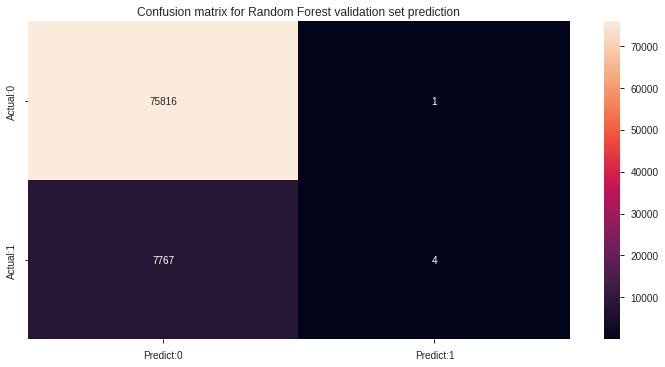

In [ ]:
from ift6758.metrics import plot_metrics

exp.log_figure("Confusion Matrix",plot_metrics.plotConfusion(y_valid,y_pred_valid, title='Confusion matrix for Random Forest validation set prediction'))

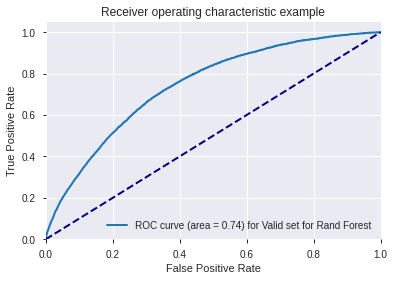

('ROC curve on validation set', None)

In [ ]:
"ROC curve on validation set",plot_metrics.plot_roc([y_valid],[y_proba_val],["Valid set for Rand Forest"])

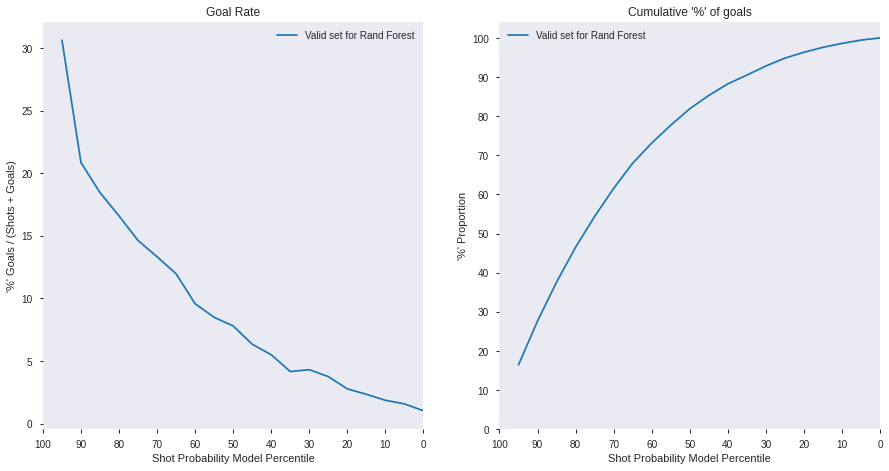

In [ ]:
plot_metrics.plot_percentile([y_valid],[y_proba_val],bin_width=5,plot_labels=["Valid set for Rand Forest"])

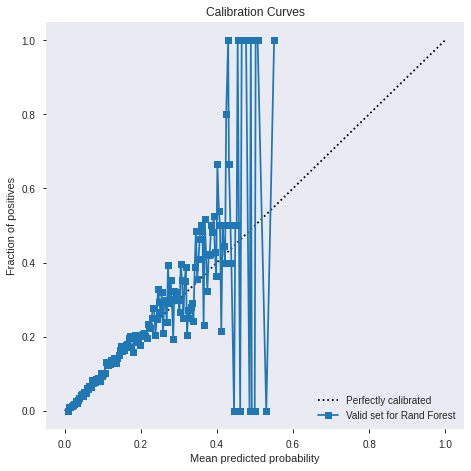

In [ ]:
plot_metrics.plot_calibration([y_valid],[y_proba_val],plot_labels=["Valid set for Rand Forest"])

### after I dl the img, export them on Comet

In [ ]:
exp.log_image("figures/roc.png",name="ROC with validation set")

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=40416214fcc94006b0ab97bf72e15a30&experimentKey=e63f825c8ea044f5becbd0755d4bee36',
 'imageId': '40416214fcc94006b0ab97bf72e15a30',
 'web': 'https://www.comet.ml/api/image/download?imageId=40416214fcc94006b0ab97bf72e15a30&experimentKey=e63f825c8ea044f5becbd0755d4bee36'}

In [ ]:
exp.log_image("figures/percentile.png",name="Percentile with validation set")
exp.log_image("figures/calibration.png",name="Calibrationn figure with validation set")

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=b42f7c346b204ca5be7f6a361d82f7a0&experimentKey=e63f825c8ea044f5becbd0755d4bee36',
 'imageId': 'b42f7c346b204ca5be7f6a361d82f7a0',
 'web': 'https://www.comet.ml/api/image/download?imageId=b42f7c346b204ca5be7f6a361d82f7a0&experimentKey=e63f825c8ea044f5becbd0755d4bee36'}

# On test sets (regular and playoff)

In [ ]:
pred_regular  = model.predict(X_test_regular)
proba_regular = model.predict_proba(X_test_regular)[:,1] # get the proba of having a goal (pred=1)
score_regular = model.score(X_test_regular,y_label_regular)
score_regular

0.9070457764517976

In [ ]:
exp.log_metric("Test score on Regular Season", score_regular)

In [ ]:
pred_playoff  = model.predict(X_test_playoff)
proba_playoff = model.predict_proba(X_test_playoff)[:,1] # get the proba of having a goal (pred=1)
score_playoff = model.score(X_test_playoff,y_test_playoff)
score_playoff

0.9148936170212766

In [ ]:
exp.log_metric("Test score on Playoffs (2019)", score_playoff)

## Export model

In [ ]:
weights_dir = "../ift6758/models/weights"
experiment = "Random-forest-test-regular-with-FE2"
predscore_val_dict={}

In [ ]:
import joblib

predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['true_test_reg_label']=y_label_regular
predscore_val_dict[experiment]['proba']=proba_regular
predscore_val_dict[experiment]['prediction']=pred_regular

## Dumping model
filename=f"{weights_dir}/{experiment}.pkl"
joblib.dump(model,filename)

['../ift6758/models/weights/Random-forest-test-regular-with-FE2.pkl']

In [ ]:
weights_dir = "../ift6758/models/weights"
experiment = "Random-forest-test-playoff-with-FE2"
predscore_val_dict={}

import joblib

predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['true_test_reg_label']=y_test_playoff
predscore_val_dict[experiment]['proba']=proba_playoff
predscore_val_dict[experiment]['prediction']=pred_playoff

## Dumping model
filename=f"{weights_dir}/{experiment}.pkl"
joblib.dump(model,filename)

['../ift6758/models/weights/Random-forest-test-playoff-with-FE2.pkl']

In [ ]:
exp.log_model("Random Forest", "../ift6758/models/weights/Random-forest-with-FE2.pkl")

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=1467cfb3eeea4364a6f6ad97d4c06463&experimentKey=e63f825c8ea044f5becbd0755d4bee36',
 'assetId': '1467cfb3eeea4364a6f6ad97d4c06463',
 'web': 'https://www.comet.ml/api/asset/download?assetId=1467cfb3eeea4364a6f6ad97d4c06463&experimentKey=e63f825c8ea044f5becbd0755d4bee36'}

# Plot

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     60194
           1       0.80      0.00      0.00      6172

    accuracy                           0.91     66366
   macro avg       0.85      0.50      0.48     66366
weighted avg       0.90      0.91      0.86     66366

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      7139
           1       0.00      0.00      0.00       663

    accuracy                           0.91      7802
   macro avg       0.46      0.50      0.48      7802
weighted avg       0.84      0.91      0.87      7802



{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=95a03cb82bf74dbab74e1de03d888920&experimentKey=e63f825c8ea044f5becbd0755d4bee36',
 'imageId': '95a03cb82bf74dbab74e1de03d888920',
 'web': 'https://www.comet.ml/api/image/download?imageId=95a03cb82bf74dbab74e1de03d888920&experimentKey=e63f825c8ea044f5becbd0755d4bee36'}

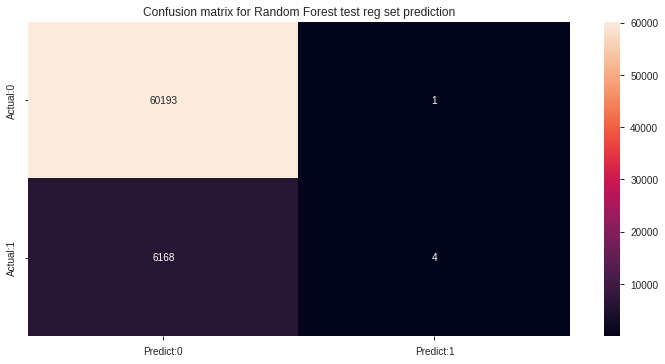

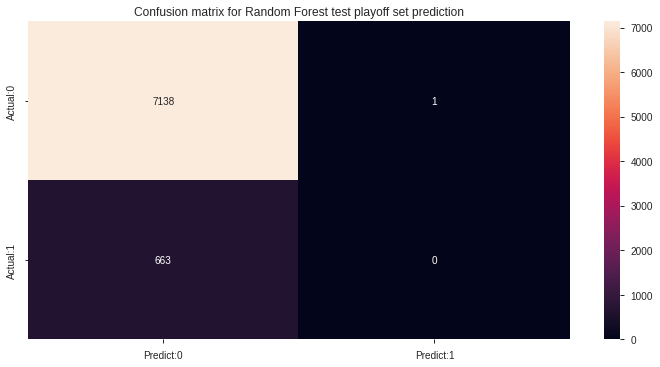

In [ ]:
from ift6758.metrics import plot_metrics

exp.log_figure("Confusion Matrix for regular season test set",plot_metrics.plotConfusion(y_label_regular,pred_regular, title='Confusion matrix for Random Forest test reg set prediction'))
exp.log_figure("Confusion Matrix for playoff season test set", plot_metrics.plotConfusion(y_test_playoff,pred_playoff, title='Confusion matrix for Random Forest test playoff set prediction'))

In [ ]:
label_list = [y_label_regular, y_test_playoff]
proba_list = [proba_regular,proba_playoff]
pred_list = [pred_regular,pred_playoff]
title_list = ["Regular Season", "Playoff"]

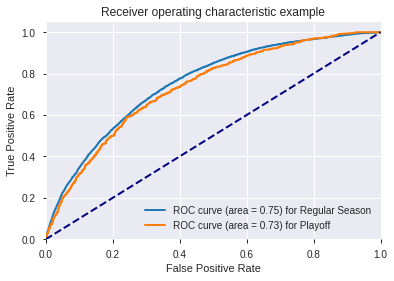

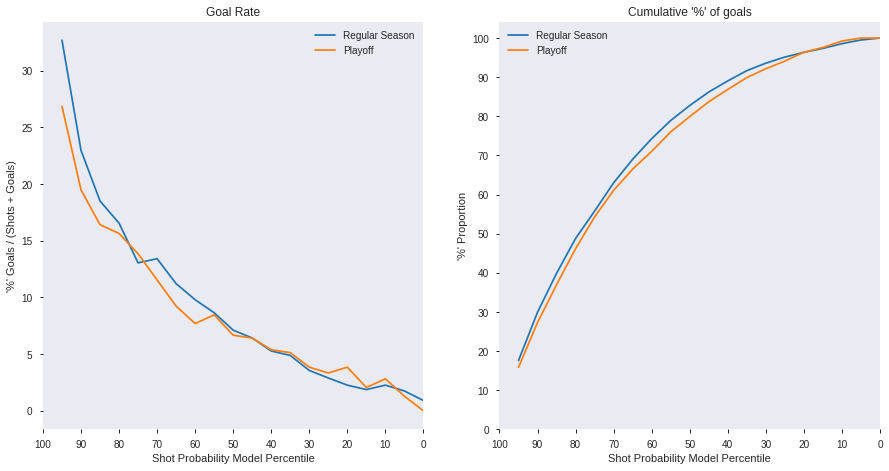

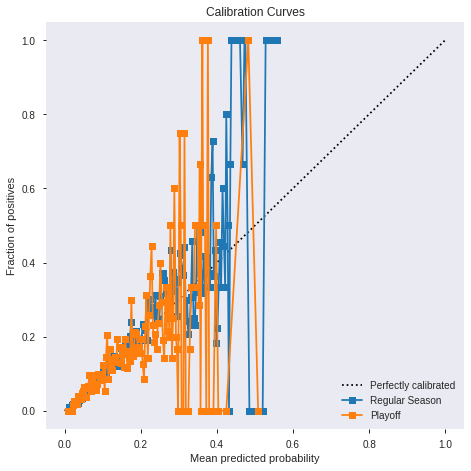

In [ ]:
plot_metrics.plot_roc(label_list,proba_list,title_list)
plot_metrics.plot_percentile(label_list,proba_list,bin_width=5,plot_labels=title_list)
plot_metrics.plot_calibration(label_list,proba_list,plot_labels=title_list)

In [ ]:
exp.log_image("figures/roc_test.png",name="Percentile with test set")
exp.log_image("figures/percentile_test.png",name="Percentile with test set")
exp.log_image("figures/calibration_test.png",name="Calibrationn figure with test set")

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=004e84d8139c406785ffe8ddbe25643b&experimentKey=e63f825c8ea044f5becbd0755d4bee36',
 'imageId': '004e84d8139c406785ffe8ddbe25643b',
 'web': 'https://www.comet.ml/api/image/download?imageId=004e84d8139c406785ffe8ddbe25643b&experimentKey=e63f825c8ea044f5becbd0755d4bee36'}

In [ ]:
exp.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/morph-e/milestone-2/e63f825c8ea044f5becbd0755d4bee36
COMET INFO:   Metrics:
COMET INFO:     Accuracy on valid (2018) set  : 0.907068000191415
COMET INFO:     Test score on Playoffs (2019) : 0.9148936170212766
COMET INFO:     Test score on Regular Season  : 0.9070457764517976
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2FM0rph3e%2Fift6758-project-main%2Fblob%2Fmain%2Fnotebooks%2Ftry_your_best_shot.ipynb
COMET INFO:   Parameters:
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     class_weight             : 1
COMET INFO:     criterion                : entropy
COMET INFO:     max_depth                : 12
COME